# Generating Toy Data/Model and Deploying to AdaFruit EdgeBadge

### Akshay Sridharan
#### Georgia Institute of Technology M.S. in Analytics Practicum Project with GE Research

Problem Statement: Design an anomaly detection workflow to detect anomalous movement using accelerometer readings. Deploy to an AdaFruit EdgeBadge for real-time inference.

### Plan of attack: 

##### Data Generation:
Toy accelerometer data will be loaded in from an AdaFruit EdgeBadge. The data will be sent to the device's serial port using the in-built AdaFruit magic_wand example code. The data will be read into Python from the serial port using pySerial (https://pyserial.readthedocs.io/en/latest/pyserial.html#overview) and further saved to a .csv for easy recreation of the workflow. It will be cleaned and stored using pandas as a multi-variate time series.

##### Data Description:
This data will consist of 3-channel accelerometer readings recorded over a 90 second interval at 25Hz. The first 60 seconds of the data will consist of "normal turbulence". This coincides with a typical, rhythmic movement of the device to synthetically emulate normal operating conditions of a machine (all is working well in our fake machine). The next 30 seconds of the data will consist of "anomalous turbulence". This coincides with an atypical, erratic movement of the device to synthetically emulate anomalous operating conditions of a machine (all is not well in our fake machine).

##### Anomaly Detection Approach:
In order to enact the anomaly detection, an autoencoder approach will be implemented. An autoencoder is a model that simply attempts to recreate the identity function for an input while minimizing the impact of overfitting. A neural network typically accomplishes this by compressing input information in intermediate layers and decompressing information in latter layers to effectively conduct lossy compression and decompression. The model is trained using the training data as both the input and response, thereby training the model to minimize compression loss caused in the smaller node cardinality intermediate layers. Thus, informally, the model is attempting to become quite good at reconstructing "normal turbulence" input signals, and will by design be quite poor at the reconstruction of "anomalous turbulence" input signals.

As this model is trained, a training loss distribution will be calculated. The loss used will be mean absolute error between input and output vectors, for the sake of simplicity. An upper threshold for the "normal turbulence" loss will be identified and used for the anomaly detection step. When streaming test or inference data to the model, normal signals will show low loss below the threshold value, while anomalous signals will lead to loss values above the threshold value. Thus, any loss calculated above the threshold value implies the input signal was anomalous.

### Importing Necessary Libraries

In [1]:
#Data creation and cleaning
import csv
from time import time
import serial
import pandas as pd
import numpy as np

#Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

#Quantization-Aware training
import tensorflow_model_optimization as tfmot

### Reading in data from serial port
Note: This step is only meant to be run for data generation. For reuse of the exact project data, the following cell may be skipped and the accompanying .csv may just be loaded in i.e. there is no need to rerun this cell unless you would like to create your own data (which requires running the magic_wand AdaFruit example prior to running the following cell).

In [ ]:
#Obtaining data generated by randomized perturbations of accelerometer (shaking EdgeBadge with intentional anomalous shake at the very end for test set)
#Run this cell while running magic_wand example on Adafruit EdgeBadge to generate data then pulling values from Serial port
#Loop ends after samples have been collected

#Serial port will have to be user set and will need to correspond to EdgeBadge serial port value (found in Arduino IDE)
serial_port = '/dev/cu.usbmodem143101'
ser = serial.Serial(serial_port, timeout=1)

f = open("df.csv", "a+")
writer = csv.writer(f, delimiter=',')

#The number of samples will equal the recording frequency (25Hz) multiplied by the duration of the sample (90 seconds)
num_samples = 25*90

for i in range(num_samples):
    s = ser.readline().decode()
    if s != "":
        rows = [float(x) for x in s.split(',')]
        # Insert local time to list's first position
        rows.insert(0, time())
        print(rows)
        writer.writerow(rows)
        f.flush()
    
print("Collection finished!")

### Loading data from .csv

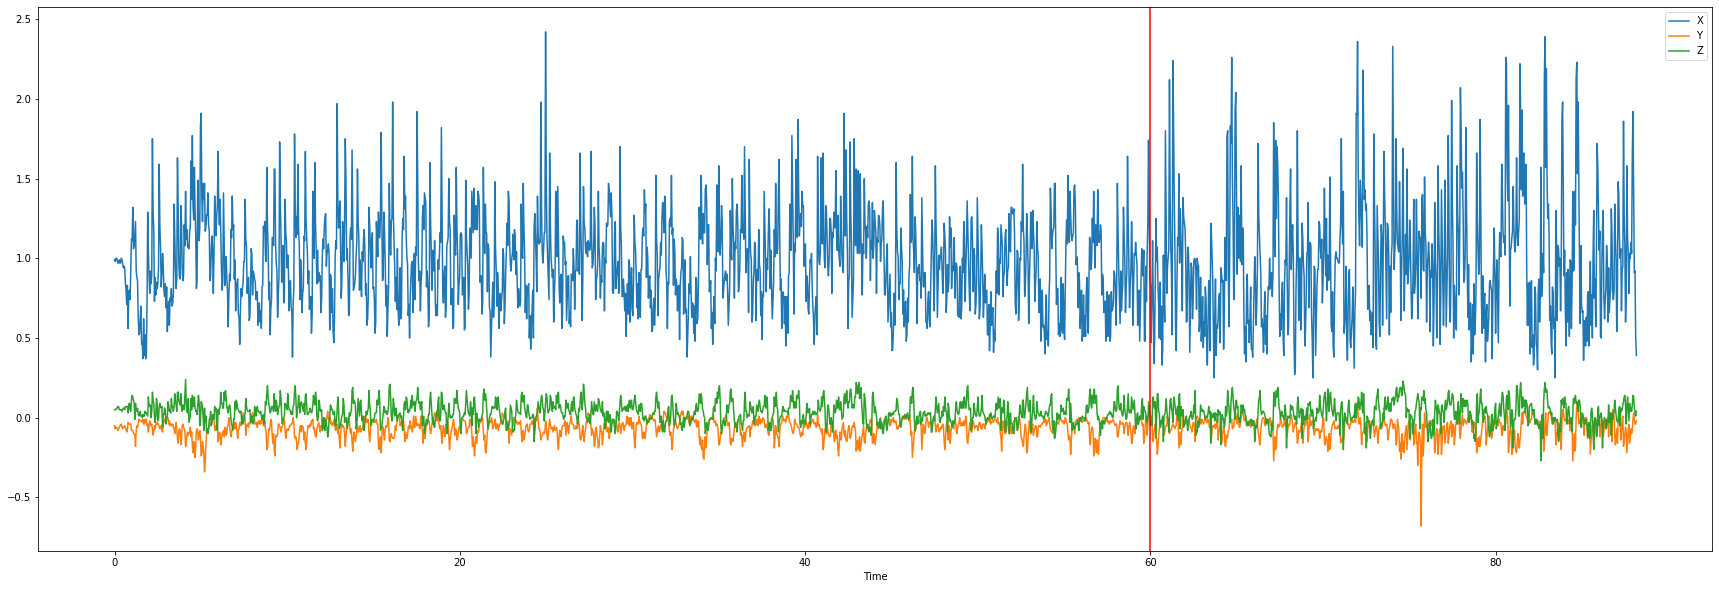

In [2]:
#Reading in raw data
data = pd.read_csv('df.csv', names=['Time', 'X', 'Y', 'Z'])

#Changing time to seconds elapsed
data.iloc[:,0] -= np.min(data.iloc[:,0])

#Displaying plot of accelerometer data across total time period
data.plot(x='Time', y=["X", "Y", 'Z'],
        kind="line", figsize=(30, 10))
plt.axvline(x=60, color='red')
plt.show()

In the above plot, the differences between the baseline 'normal turbulence' between the two increments can be observed, particularly in the X-axis accelerometer readings.

### Creating Train-Test Split and Formatting data

Splitting data into test and train samples. Train-Test split for each increment will be approximately 40-60.

In [3]:
train = data.iloc[0:int(0.4*len(data)),:]
test = data.iloc[(int(0.4*len(data))):,:]

#Setting time to be index value
traindf = train.set_index("Time", inplace=False)
testdf = test.set_index("Time", inplace=False)

#Converting traindf and testdf to arrays
train = np.array(traindf)
test = np.array(testdf)

#Reshaping data for compatibility with model [samples, timesteps, features]
train = train.reshape(train.shape[0], 1, train.shape[1])
print("Training data shape:", train.shape)
test = test.reshape(test.shape[0], 1, test.shape[1])
print("Test data shape:", test.shape)

Training data shape: (900, 1, 3)
Test data shape: (1350, 1, 3)


### Model Training

In [4]:
#Autoencoder with three dense layers and dropout
model3 = tf.keras.models.Sequential([
    Input(shape=(train.shape[1], train.shape[2]), name="input"),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(32, activation='relu'),
    Dense(train.shape[2], name = 'output'),
])


model3.compile(optimizer='adam', loss='mae')
model3.summary()

# Fitting model to the data
nb_epochs = 100
batch_size = 10
history1 = model3.fit(train, train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 32)             128       
                                                                 
 dense_1 (Dense)             (None, 1, 8)              264       
                                                                 
 dense_2 (Dense)             (None, 1, 32)             288       
                                                                 
 output (Dense)              (None, 1, 3)              99        
                                                                 
Total params: 779
Trainable params: 779
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
86/86 [==============================] - 1s 3ms/step - loss: 0.1670 - val_loss: 0.0541
Epoch 2/100
86/86 [==============================] - 0s 921us/step - loss: 0.0358 - val_los

##### Brief Modeling Note:

A very simple neural network was utilized in this portion of the project as the milestone is simply intended as a proof-of-concept. Issues arose when testing more complicated models (e.g. LSTM Autoencoder) due to subgraph structure and interpreter capabilities in the Arduino TensorFlow Lite packages. Further work will be required to explore the capacity for complex model support. This is the primary reason for the relatively poor training loss performance of the model.

### Model Loss Plots

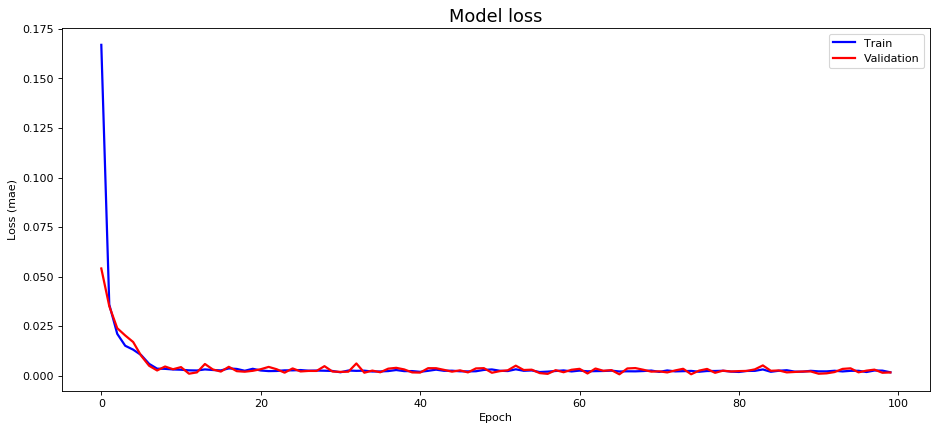

In [5]:
#Plotting training and validation loss for model
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history1['loss'], 'b', label='Train', linewidth=2)
ax.plot(history1['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

29/29 [==============================] - 0s 1ms/step
Threshold Value: 0.0018241685796518714
29/29 [==============================] - 0s 737us/step


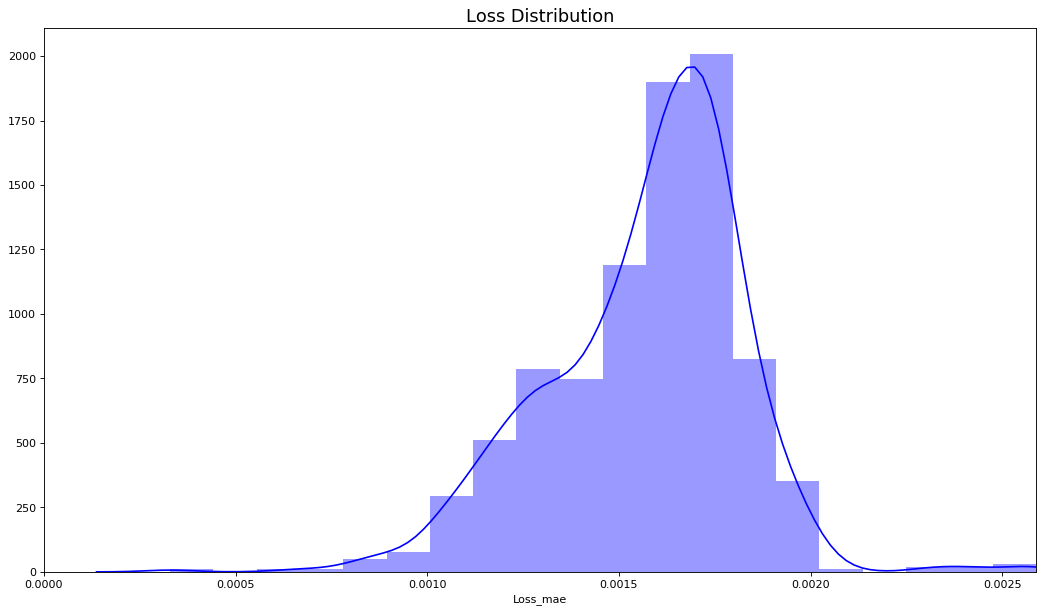

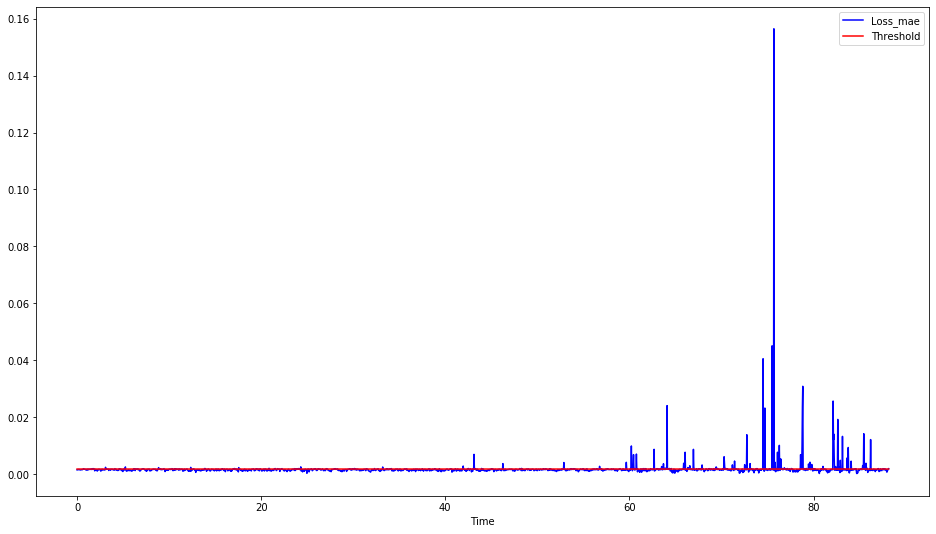

In [6]:
# Plotting distribution of loss function to establish reasonable threshold for anomaly detection

X_pred1 = model3.predict(train)
X_pred1 = X_pred1.reshape(X_pred1.shape[0], X_pred1.shape[2])
X_pred1 = pd.DataFrame(X_pred1, columns=data.columns[1:4])
X_pred1.index = data.iloc[0:int(0.4*len(data)),0]

scored1 = pd.DataFrame(index=data.iloc[0:int(0.4*len(data)),0])
Xtrain1 = train.reshape(train.shape[0], train.shape[2])
scored1['Loss_mae'] = np.mean(np.abs(X_pred1-Xtrain1), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored1['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,np.max(scored1['Loss_mae'])])

#Defining threshold values for loss anomaly detection as one standard deviation above the mean
thresh_reg = np.mean(scored1['Loss_mae']) + np.std(scored1['Loss_mae'])
print(f'Threshold Value: {thresh_reg}')

#Computing test set loss and applying threshold value for anomaly detection
X_pred1 = model3.predict(test)
X_pred1 = X_pred1.reshape(X_pred1.shape[0], X_pred1.shape[2])
X_pred1 = pd.DataFrame(X_pred1, columns=data.columns[1:4])
X_pred1.index = data.iloc[(int(0.4*len(data))):,0]

scored1 = pd.DataFrame(index= data.iloc[(int(0.4*len(data))):,0])
Xtest1 = test.reshape(test.shape[0], test.shape[2])
scored1['Loss_mae'] = np.mean(np.abs(X_pred1-Xtest1), axis = 1)
scored1['Threshold'] = thresh_reg
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

#Computing train set loss and applying threshold value
X_pred1_train = model3.predict(train)
X_pred1_train = X_pred1_train.reshape(X_pred1_train.shape[0], X_pred1_train.shape[2])
X_pred1_train = pd.DataFrame(X_pred1_train, columns=data.columns[1:4])
X_pred1_train.index = data.iloc[0:int(0.4*len(data)),0]

scored1_train = pd.DataFrame(index= data.iloc[0:int(0.4*len(data)),0])
Xtrain1 = train.reshape(train.shape[0], train.shape[2])
scored1_train['Loss_mae'] = np.mean(np.abs(X_pred1_train-Xtrain1), axis = 1)
scored1_train['Threshold'] = thresh_reg
scored1_train['Anomaly'] = scored1_train['Loss_mae'] > scored1_train['Threshold']

#Merging train and test loss data
scored_1 = pd.concat([scored1_train, scored1])

#Visualizing model output in period preceding anomalous turbulence
scored_1.plot(logy=False,  figsize=(16,9), color=['blue','red'])

As there is some noise in the normal turbulence data, a few values in the test set that represent normal turbulence have MAE's that exceed the anomaly detection threshold.

## Getting this to run on a microcontroller

### Saving TensorFlow model to identify size and compression factor

In [7]:
#Saving Tensorflow Model in Protocol Buffer Format
model3.save("model3")

INFO:tensorflow:Assets written to: model3/assets


### Define function to export C Array from TFLite model

In [8]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

    c_str = ''

  # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
    c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

    # Construct string from hex
        hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

  # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

#### Converting model to TFLite, then C array by first fixing the input size using a concrete function then converting from saved model

In [9]:
run_model = tf.function(lambda x: model3(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 1
INPUT_SIZE = 3
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model3.inputs[0].dtype))

# model directory.
MODEL_DIR = "anomaly_det_mod"
model3.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=tflite_model)

#Saving models
with open('model3.tflite', 'wb') as f:
    f.write(tflite_model)
    
with open('c_model3' + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, 'c_model3'))

INFO:tensorflow:Assets written to: anomaly_det_mod/assets
=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the FULLY_CONNECTED op takes
tensor #0 and tensor #5 and tensor #2 as input and produces tensor #9 as output.

Subgraph#0 main(T#0) -> [T#12]
  Op#0 FULLY_CONNECTED(T#0, T#5, T#2) -> [T#9]
  Op#1 FULLY_CONNECTED(T#9, T#6, T#4) -> [T#10]
  Op#2 FULLY_CONNECTED(T#10, T#7, T#3) -> [T#11]
  Op#3 FULLY_CONNECTED(T#11, T#8, T#1) -> [T#12]

Tensors of Subgraph#0
  T#0(serving_default_x:0) shape:[1, 1, 3], type:FLOAT32
  T#1(sequential/output/BiasAdd/ReadVariableOp) shape:[3], type:FLOAT32 RO 12 bytes
  T#2(sequential/dense/BiasAdd/ReadVariableOp) shape:[32], type:FLOAT32 RO 128 bytes
  T#3(sequential/dense_2/BiasAdd/ReadVariableOp) shape:[32], type:FLOAT32 RO 128 bytes
  T#4(sequential/dense_1/BiasAdd/ReadVariableOp) shape:[8], type:FLOAT32 RO 32 bytes
  T#5(sequential/den

#### Alternative Converting model to TFLite, then C array

In [10]:
#Converting models to tflite models
converter_alt = tf.lite.TFLiteConverter.from_keras_model(model3)

# converter_alt.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
# converter_alt._experimental_lower_tensor_list_ops = False
# converter_alt.optimizations =  [tf.lite.Optimize.DEFAULT]
tflite_model_alt = converter_alt.convert()

tf.lite.experimental.Analyzer.analyze(model_content=tflite_model_alt)

#Saving models
with open('model_alt_3.tflite', 'wb') as f:
    f.write(tflite_model_alt)

with open('c_model_alt_3' + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_alt, 'c_model_alt_3'))

INFO:tensorflow:Assets written to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmpops9vtb4/assets
=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the SHAPE op takes
tensor #0 as input and produces tensor #15 as output.

Subgraph#0 main(T#0) -> [T#58]
  Op#0 SHAPE(T#0) -> [T#15]
  Op#1 GATHER(T#15, T#6) -> [T#16]
  Op#2 REDUCE_PROD(T#16, T#8) -> [T#17]
  Op#3 GATHER(T#15, T#5) -> [T#18]
  Op#4 REDUCE_PROD(T#18, T#8) -> [T#19]
  Op#5 PACK(T#19, T#17) -> [T#20]
  Op#6 CONCATENATION(T#18, T#9) -> [T#21]
  Op#7 RESHAPE(T#0, T#20) -> [T#22]
  Op#8 FULLY_CONNECTED(T#22, T#11, T#-1) -> [T#23]
  Op#9 RESHAPE(T#23, T#21) -> [T#24]
  Op#10 ADD(T#24, T#2) -> [T#25]
  Op#11 SHAPE(T#25) -> [T#26]
  Op#12 GATHER(T#26, T#5) -> [T#27]
  Op#13 REDUCE_PROD(T#27, T#8) -> [T#28]
  Op#14 CONCATENATION(T#27, T#10) -> [T#29]
  Op#15 GATHER(T#26, T#6) -> [T#30]
  Op#16 REDUCE_PROD(T#30, T#

## Quantization Aware Training with Integer Quantization

In [11]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model3)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='mae')

q_aware_model.summary()

# Fitting model to the data
nb_epochs = 100
batch_size = 10
history1 = q_aware_model.fit(train, train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 1, 3)             3         
 er)                                                             
                                                                 
 quant_dense (QuantizeWrappe  (None, 1, 32)            133       
 rV2)                                                            
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 1, 8)             269       
 perV2)                                                          
                                                                 
 quant_dense_2 (QuantizeWrap  (None, 1, 32)            293       
 perV2)                                                          
                                                                 
 quant_output (QuantizeWrapp  (None, 1, 3)             1

Epoch 69/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0094 - val_loss: 0.0064
Epoch 70/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.0075
Epoch 71/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0098 - val_loss: 0.0071
Epoch 72/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0093 - val_loss: 0.0074
Epoch 73/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0095 - val_loss: 0.0089
Epoch 74/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0076
Epoch 75/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0097 - val_loss: 0.0075
Epoch 76/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 77/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 78/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss: 0.0079


In [12]:
def representative_data_gen():
    vals = tf.data.Dataset.from_tensor_slices(train).batch(1)
    for i in vals.take(100):#batch size
        i = tf.dtypes.cast(i, tf.float32)
        yield [i]

In [13]:
run_model = tf.function(lambda x: q_aware_model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 1
INPUT_SIZE = 3
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], q_aware_model.inputs[0].dtype))

# model directory.
MODEL_DIR = "anomaly_det_mod"
q_aware_model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=quantized_tflite_model)

#Saving models
with open('model3_qai.tflite', 'wb') as f:
    f.write(quantized_tflite_model)
    
with open('c_model3_qai' + '.h', 'w') as file:
    file.write(hex_to_c_array(quantized_tflite_model, 'c_model3_qai'))

INFO:tensorflow:Assets written to: anomaly_det_mod/assets


INFO:tensorflow:Assets written to: anomaly_det_mod/assets


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the QUANTIZE op takes
tensor #0 as input and produces tensor #3 as output.

Subgraph#0 main(T#0) -> [T#18]
  Op#0 QUANTIZE(T#0) -> [T#3]
  Op#1 RESHAPE(T#3, T#1) -> [T#4]
  Op#2 FULLY_CONNECTED(T#4, T#5, T#6) -> [T#7]
  Op#3 FULLY_CONNECTED(T#7, T#8, T#9) -> [T#10]
  Op#4 FULLY_CONNECTED(T#10, T#11, T#12) -> [T#13]
  Op#5 FULLY_CONNECTED(T#13, T#14, T#15) -> [T#16]
  Op#6 RESHAPE(T#16, T#2) -> [T#17]
  Op#7 DEQUANTIZE(T#17) -> [T#18]

Tensors of Subgraph#0
  T#0(serving_default_x:0) shape:[1, 1, 3], type:FLOAT32
  T#1(sequential/quant_dense/Tensordot/Reshape/shape) shape:[2], type:INT32 RO 8 bytes
  T#2(sequential/quant_output/Tensordot/shape) shape:[3], type:INT32 RO 12 bytes
  T#3(tfl.quantize) shape:[1, 1, 3], type:INT8
  T#4(sequential/quant_dense/Tensordot/Reshape;sequential/quantize_layer/AllValuesQuantize/FakeQuantW

In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.representative_dataset = representative_data_gen
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# # Set the input and output tensors to uint8 (APIs added in r2.3)
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

quantized_tflite_model_alt = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=quantized_tflite_model_alt)


#Saving models
with open('model_alt_3_qai.tflite', 'wb') as f:
    f.write(quantized_tflite_model_alt)

with open('c_model_alt_3_qai' + '.h', 'w') as file:
    file.write(hex_to_c_array(quantized_tflite_model_alt, 'c_model_alt_3_qai'))

INFO:tensorflow:Assets written to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmp0gey4rmk/assets


INFO:tensorflow:Assets written to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmp0gey4rmk/assets
/Users/akshay/opt/anaconda3/lib/python3.7/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the QUANTIZE op takes
tensor #0 as input and produces tensor #15 as output.

Subgraph#0 main(T#0) -> [T#60]
  Op#0 QUANTIZE(T#0) -> [T#15]
  Op#1 SHAPE(T#15) -> [T#16]
  Op#2 GATHER(T#16, T#1) -> [T#17]
  Op#3 REDUCE_PROD(T#17, T#2) -> [T#18]
  Op#4 CONCATENATION(T#17, T#3) -> [T#19]
  Op#5 GATHER(T#16, T#4) -> [T#20]
  Op#6 REDUCE_PROD(T#20, T#2) -> [T#21]
  Op#7 PACK(T#18, T#21) -> [T#22]
  Op#8 RESHAPE(T#15, T#22) -> [T#23]
  Op#9 FULLY_CONNECTED(T#23, T#7, T#-1) -> [T#24]
  Op#10 RESHAPE(T#24, T#19) -> [T#25]
  Op#11 ADD(T#25, T#8) -> [T#26]
  Op#12 SHAPE(T#26) -> [T#27]
  Op#13 GATHER(T#27, T#1) -> [T#28]
  Op#14 REDUCE_PROD(T#28, T#2) -> [T#29]
  Op#15 CONCATENATION(T#28, T#5) -> [T#30]
  Op#16 GATHER(T#27, T#4) -> [T#31]
  Op#17 REDUCE_PROD(T#31, T#2) -> [T#32]
  Op#18 PACK(T#29, T#32) -> [T#33]
  Op#19 RESHAPE(T#26

### Model Loss Plots

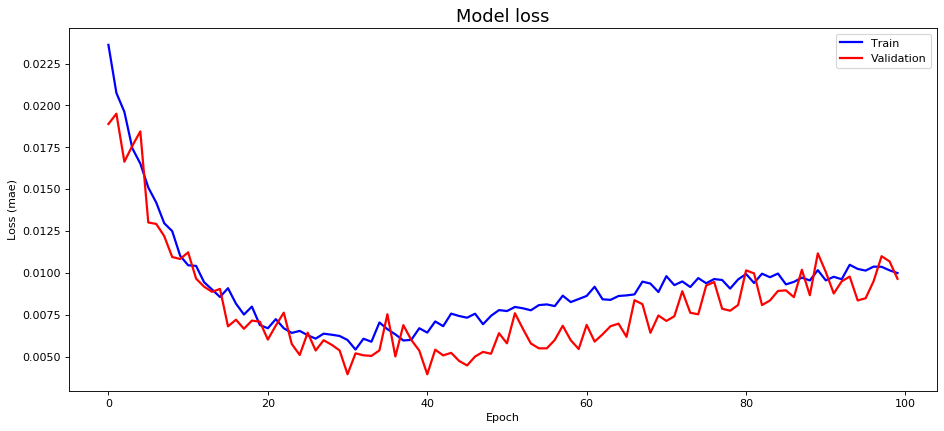

In [15]:
#Plotting training and validation loss for model
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history1['loss'], 'b', label='Train', linewidth=2)
ax.plot(history1['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

Threshold Value: 0.03527914033944166


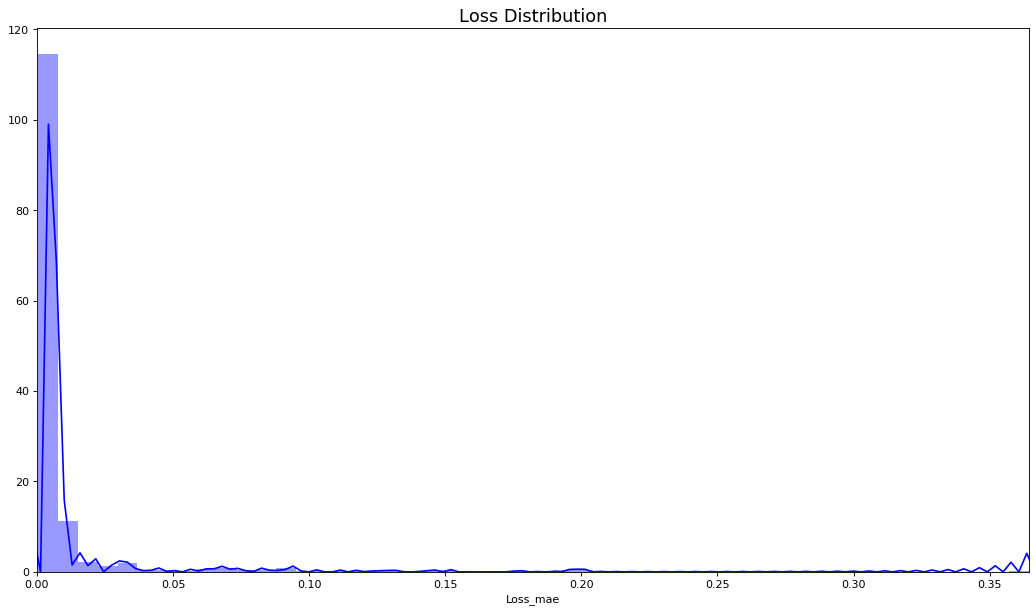

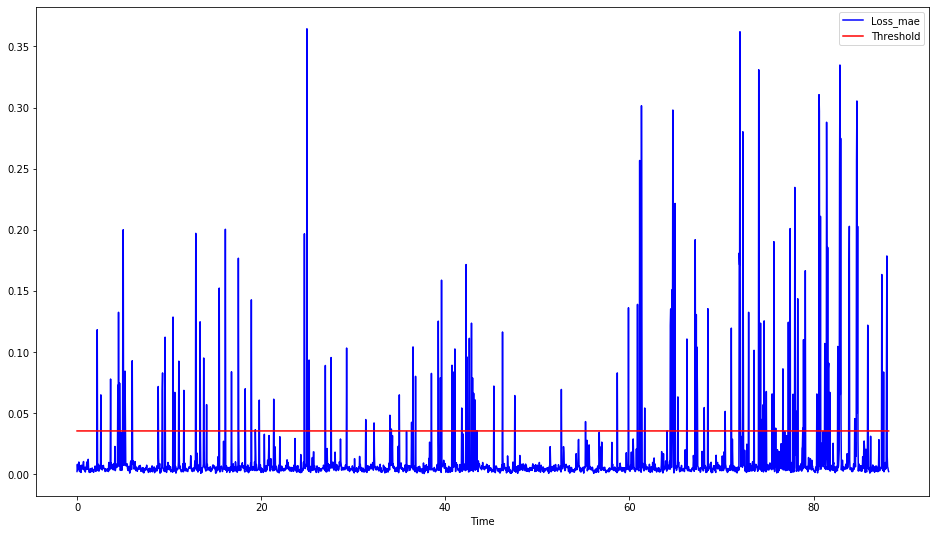

In [16]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

# Train Predictions from TFLite model
tfl1_pred = np.empty((900,1,3))
for i in range(len(train)):
    interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i,0,:] = result
    
# Computing MAE Loss across all training points
loss = np.mean(np.abs(tfl1_pred - train), axis = 2)

# Plotting distribution of loss function to establish reasonable threshold for anomaly detection
scored1_train = pd.DataFrame(index=data.iloc[0:int(0.4*len(data)),0])
scored1_train['Loss_mae'] = loss
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored1_train['Loss_mae'], bins = 50, kde= True, color = 'blue');
plt.xlim([0.0,np.max(scored1_train['Loss_mae'])])

#Defining threshold values for loss anomaly detection as one standard deviation above the mean
thresh_qai = np.mean(scored1_train['Loss_mae']) + np.std(scored1_train['Loss_mae'])
print(f'Threshold Value: {thresh_qai}')

#Applying threshold value
scored1_train['Threshold'] = thresh_qai
scored1_train['Anomaly'] = scored1_train['Loss_mae'] > scored1_train['Threshold']

# Test Predictions from TFLite model
tfl1_pred = np.empty((1350,1,3))
for i in range(len(test)):
    interpreter.set_tensor(input_details[0]["index"], test.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i,0,:] = result

# Computing MAE Loss across all test points
loss = np.mean(np.abs(tfl1_pred - test), axis = 2)
    
#Computing test set loss and applying threshold value for anomaly detection
scored1 = pd.DataFrame(index= data.iloc[(int(0.4*len(data))):,0])
scored1['Loss_mae'] = loss
scored1['Threshold'] = thresh_qai
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

##Merging train and test loss data
scored_1 = pd.concat([scored1_train, scored1])

#Visualizing model output in full period
scored_1.plot(logy=False,  figsize=(16,9), color=['blue','red'])


Threshold Value: 0.03574804757384885


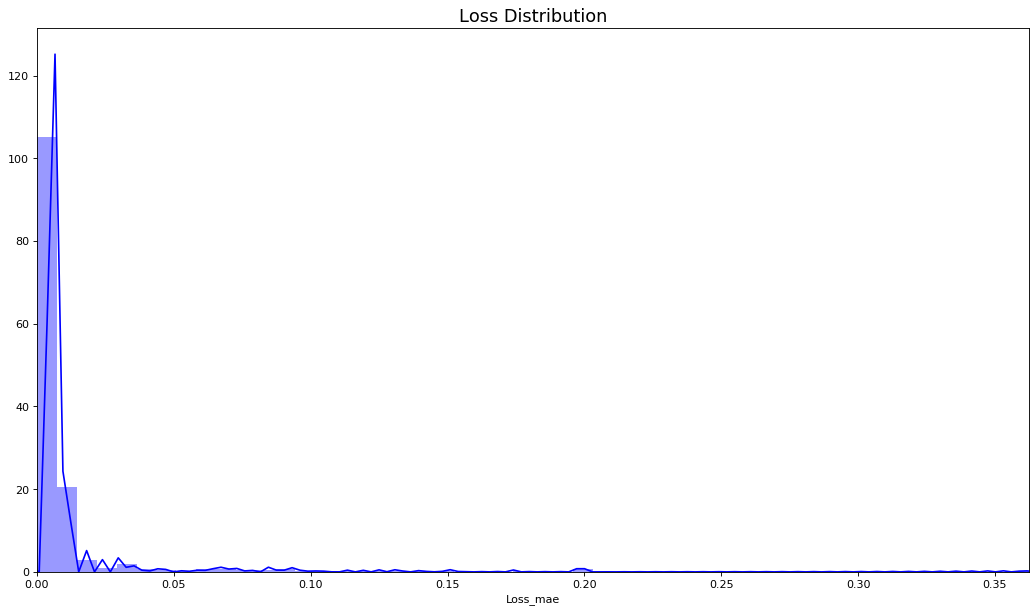

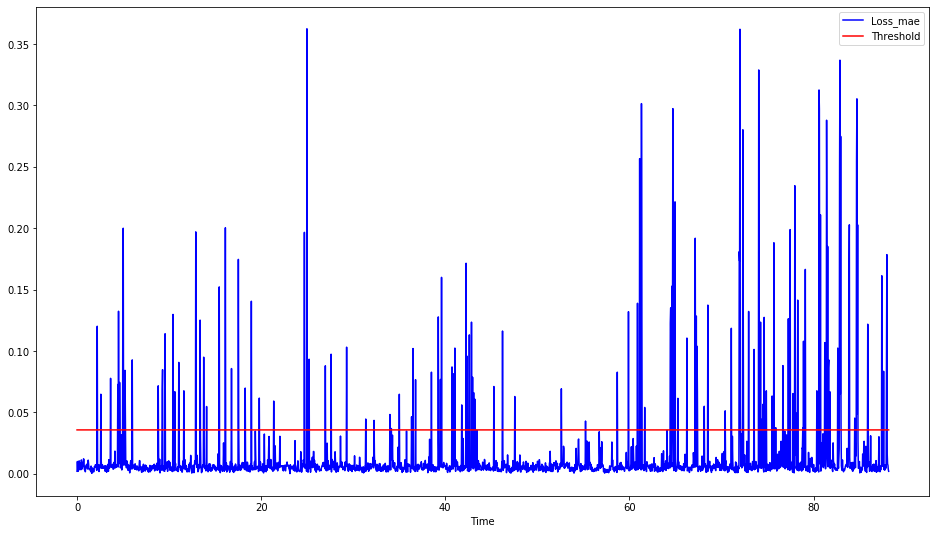

In [17]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model_alt)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

# Train Predictions from TFLite model
tfl1_pred = np.empty((900,1,3))
for i in range(len(train)):
    interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i,0,:] = result
    
# Computing MAE Loss across all training points
loss = np.mean(np.abs(tfl1_pred - train), axis = 2)

# Plotting distribution of loss function to establish reasonable threshold for anomaly detection
scored1_train = pd.DataFrame(index=data.iloc[0:int(0.4*len(data)),0])
scored1_train['Loss_mae'] = loss
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored1_train['Loss_mae'], bins = 50, kde= True, color = 'blue');
plt.xlim([0.0,np.max(scored1_train['Loss_mae'])])

#Defining threshold values for loss anomaly detection as one standard deviation above the mean
thresh_qai_alt = np.mean(scored1_train['Loss_mae']) + np.std(scored1_train['Loss_mae'])
print(f'Threshold Value: {thresh_qai_alt}')

#Applying threshold value
scored1_train['Threshold'] = thresh_qai_alt
scored1_train['Anomaly'] = scored1_train['Loss_mae'] > scored1_train['Threshold']

# Test Predictions from TFLite model
tfl1_pred = np.empty((1350,1,3))
for i in range(len(test)):
    interpreter.set_tensor(input_details[0]["index"], test.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i,0,:] = result

# Computing MAE Loss across all test points
loss = np.mean(np.abs(tfl1_pred - test), axis = 2)
    
#Computing test set loss and applying threshold value for anomaly detection
scored1 = pd.DataFrame(index= data.iloc[(int(0.4*len(data))):,0])
scored1['Loss_mae'] = loss
scored1['Threshold'] = thresh_qai_alt
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

##Merging train and test loss data
scored_1 = pd.concat([scored1_train, scored1])

#Visualizing model output in full period
scored_1.plot(logy=False,  figsize=(16,9), color=['blue','red'])


In [18]:
def train_loss(model):
    # Run the model with TensorFlow Lite
    interpreter = tf.lite.Interpreter(model_content=model)
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()
    output_details = interpreter.get_output_details()

    #Predictions from TFLite model
    tfl1_pred = np.empty((900,1,3))
    for i in range(len(train)):
        interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
        interpreter.invoke()
        result = interpreter.get_tensor(output_details[0]["index"])
        tfl1_pred[i,0,:] = result
    return np.mean(np.abs(tfl1_pred - train))

In [19]:
train_loss(quantized_tflite_model_alt)

0.01071868805532102

In [20]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model_alt)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

#Predictions from TFLite model
tfl2_pred = np.empty((1350,1,3))
for i in range(len(test)):
    interpreter.set_tensor(input_details[0]["index"], test.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl2_pred[i,0,:] = result

## Weight Clustering 

In [21]:
import tempfile
import zipfile
import os

In [22]:
_, keras_file = tempfile.mkstemp('.h5')
print('Saving model to: ', keras_file)
tf.keras.models.save_model(model3, keras_file, include_optimizer=False)

Saving model to:  /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmp2wl2p330.h5


In [51]:
#Autoencoder with three dense layers and dropout
model3 = tf.keras.models.Sequential([
    Input(shape=(train.shape[1], train.shape[2]), name="input"),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(32, activation='relu'),
    Dense(train.shape[2], name = 'output'),
])


model3.compile(optimizer='adam', loss='mae')
model3.summary()

# Fitting model to the data
nb_epochs = 100
batch_size = 10
history1 = model3.fit(train, train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 32,
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS
}

# Cluster a whole model
clustered_model = cluster_weights(model3, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

clustered_model.compile(
  loss='mae',
  optimizer=opt)

clustered_model.summary()

# Fine-tune model
clustered_model.fit(train, train, epochs=20, batch_size=128,
                    validation_split=0.05)

clustered_model = tfmot.clustering.keras.strip_clustering(clustered_model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1, 32)             128       
                                                                 
 dense_10 (Dense)            (None, 1, 8)              264       
                                                                 
 dense_11 (Dense)            (None, 1, 32)             288       
                                                                 
 output (Dense)              (None, 1, 3)              99        
                                                                 
Total params: 779
Trainable params: 779
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
86/86 [==============================] - 1s 3ms/step - loss: 0.1473 - val_loss: 0.0686
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 0.0512 - val_los

In [52]:
_, clustered_keras_file = tempfile.mkstemp('.h5')
print('Saving clustered model to: ', clustered_keras_file)
tf.keras.models.save_model(clustered_model, clustered_keras_file, 
                           include_optimizer=False)

Saving clustered model to:  /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmpyn5vp4hb.h5


In [53]:
run_model = tf.function(lambda x: clustered_model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 1
INPUT_SIZE = 3
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], clustered_model.inputs[0].dtype))

# model directory.
MODEL_DIR = "anomaly_det_mod"
clustered_model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)

# converter.representative_dataset = representative_data_gen
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
clustered_tflite_model = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=clustered_tflite_model)

#Saving models
with open('model3_clust.tflite', 'wb') as f:
    f.write(clustered_tflite_model)
    
with open('c_model3_clust' + '.h', 'w') as file:
    file.write(hex_to_c_array(clustered_tflite_model, 'c_model3_clust'))

INFO:tensorflow:Assets written to: anomaly_det_mod/assets


INFO:tensorflow:Assets written to: anomaly_det_mod/assets


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the FULLY_CONNECTED op takes
tensor #0 and tensor #5 and tensor #2 as input and produces tensor #9 as output.

Subgraph#0 main(T#0) -> [T#12]
  Op#0 FULLY_CONNECTED(T#0, T#5, T#2) -> [T#9]
  Op#1 FULLY_CONNECTED(T#9, T#6, T#4) -> [T#10]
  Op#2 FULLY_CONNECTED(T#10, T#7, T#3) -> [T#11]
  Op#3 FULLY_CONNECTED(T#11, T#8, T#1) -> [T#12]

Tensors of Subgraph#0
  T#0(serving_default_x:0) shape:[1, 1, 3], type:FLOAT32
  T#1(sequential_3/output/BiasAdd/ReadVariableOp) shape:[3], type:FLOAT32 RO 12 bytes
  T#2(sequential_3/dense_9/BiasAdd/ReadVariableOp) shape:[32], type:FLOAT32 RO 128 bytes
  T#3(sequential_3/dense_11/BiasAdd/ReadVariableOp) shape:[32], type:FLOAT32 RO 128 bytes
  T#4(sequential_3/dense_10/BiasAdd/ReadVariableOp) shape:[8], type:FLOAT32 RO 32 bytes
  T#5(sequential_3/dense_9/Tensordot/MatMul) shape:[32, 3], type:F

In [54]:
converter = tf.lite.TFLiteConverter.from_keras_model(clustered_model)
# converter.representative_dataset = representative_data_gen
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# # Set the input and output tensors to uint8 (APIs added in r2.3)
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

clustered_tflite_model_alt = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=clustered_tflite_model_alt)


#Saving models
with open('model_alt_3_clust.tflite', 'wb') as f:
    f.write(clustered_tflite_model_alt)

with open('c_model_alt_3_clust' + '.h', 'w') as file:
    file.write(hex_to_c_array(clustered_tflite_model_alt, 'c_model_alt_3_clust'))

INFO:tensorflow:Assets written to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmphvr7wyow/assets


INFO:tensorflow:Assets written to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmphvr7wyow/assets


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the SHAPE op takes
tensor #0 as input and produces tensor #15 as output.

Subgraph#0 main(T#0) -> [T#58]
  Op#0 SHAPE(T#0) -> [T#15]
  Op#1 GATHER(T#15, T#6) -> [T#16]
  Op#2 REDUCE_PROD(T#16, T#8) -> [T#17]
  Op#3 GATHER(T#15, T#5) -> [T#18]
  Op#4 REDUCE_PROD(T#18, T#8) -> [T#19]
  Op#5 PACK(T#19, T#17) -> [T#20]
  Op#6 CONCATENATION(T#18, T#9) -> [T#21]
  Op#7 RESHAPE(T#0, T#20) -> [T#22]
  Op#8 FULLY_CONNECTED(T#22, T#11, T#-1) -> [T#23]
  Op#9 RESHAPE(T#23, T#21) -> [T#24]
  Op#10 ADD(T#24, T#2) -> [T#25]
  Op#11 SHAPE(T#25) -> [T#26]
  Op#12 GATHER(T#26, T#5) -> [T#27]
  Op#13 REDUCE_PROD(T#27, T#8) -> [T#28]
  Op#14 CONCATENATION(T#27, T#10) -> [T#29]
  Op#15 GATHER(T#26, T#6) -> [T#30]
  Op#16 REDUCE_PROD(T#30, T#8) -> [T#31]
  Op#17 PACK(T#28, T#31) -> [T#32]
  Op#18 RESHAPE(T#25, T#32) -> [T#33]
  Op#19 FULLY_CON

In [55]:
train_loss(clustered_tflite_model)

0.011099317356488772

Threshold Value: 0.021181780870738333


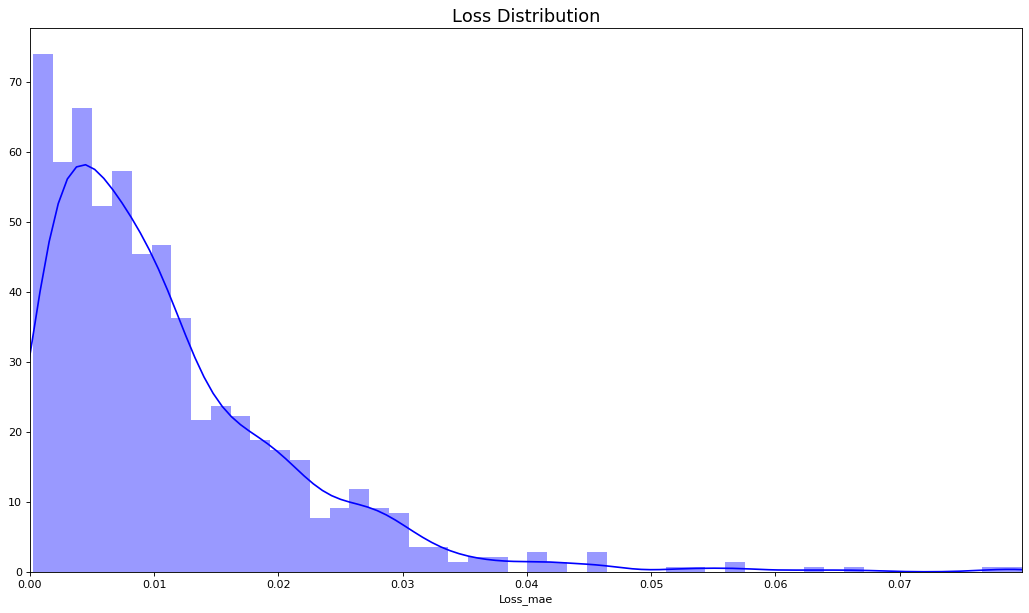

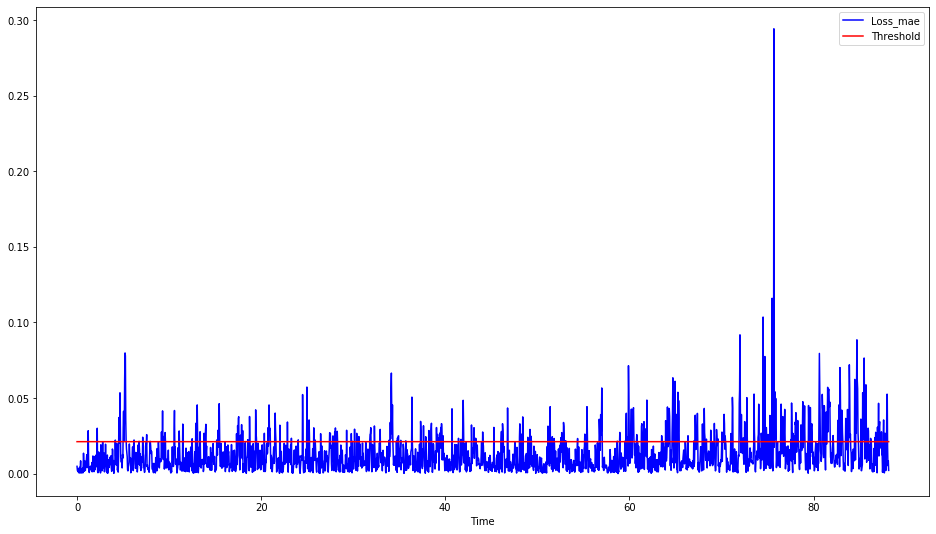

In [187]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=clustered_tflite_model)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

# Train Predictions from TFLite model
tfl1_pred = np.empty((900,1,3))
for i in range(len(train)):
    interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i,0,:] = result
    
# Computing MAE Loss across all training points
loss = np.mean(np.abs(tfl1_pred - train), axis = 2)

# Plotting distribution of loss function to establish reasonable threshold for anomaly detection
scored1_train = pd.DataFrame(index=data.iloc[0:int(0.4*len(data)),0])
scored1_train['Loss_mae'] = loss
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored1_train['Loss_mae'], bins = 50, kde= True, color = 'blue');
plt.xlim([0.0,np.max(scored1_train['Loss_mae'])])

#Defining threshold values for loss anomaly detection as one standard deviation above the mean
thresh_clust = np.mean(scored1_train['Loss_mae']) + np.std(scored1_train['Loss_mae'])
print(f'Threshold Value: {thresh_clust}')

#Applying threshold value
scored1_train['Threshold'] = thresh_clust
scored1_train['Anomaly'] = scored1_train['Loss_mae'] > scored1_train['Threshold']

# Test Predictions from TFLite model
tfl1_pred = np.empty((1350,1,3))
for i in range(len(test)):
    interpreter.set_tensor(input_details[0]["index"], test.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i,0,:] = result

# Computing MAE Loss across all test points
loss = np.mean(np.abs(tfl1_pred - test), axis = 2)
    
#Computing test set loss and applying threshold value for anomaly detection
scored1 = pd.DataFrame(index= data.iloc[(int(0.4*len(data))):,0])
scored1['Loss_mae'] = loss
scored1['Threshold'] = thresh_clust
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

##Merging train and test loss data
scored_1 = pd.concat([scored1_train, scored1])

#Visualizing model output in full period
scored_1.plot(logy=False,  figsize=(16,9), color=['blue','red'])


Threshold Value: 0.021181780870738333


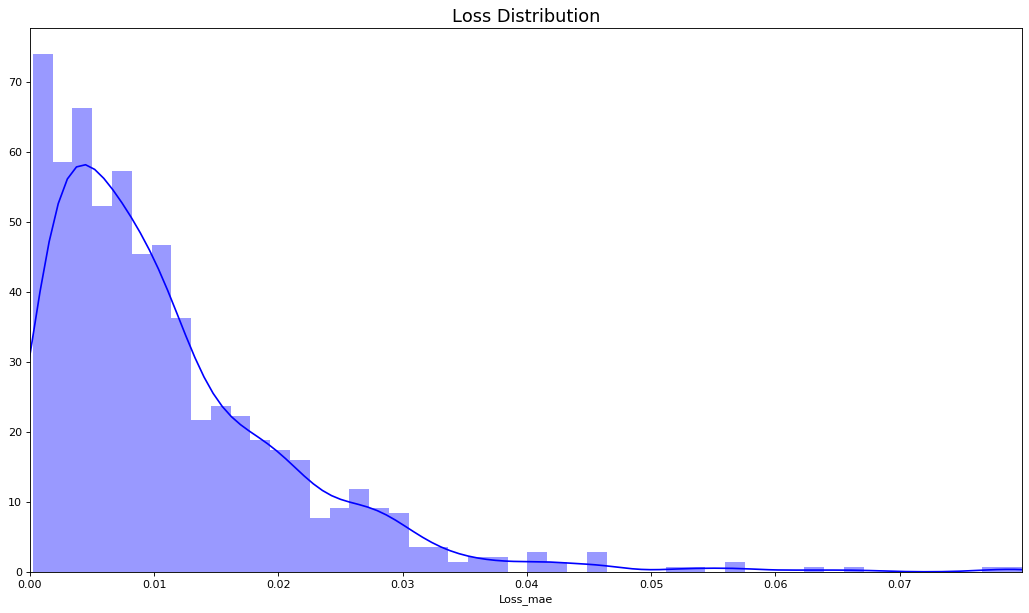

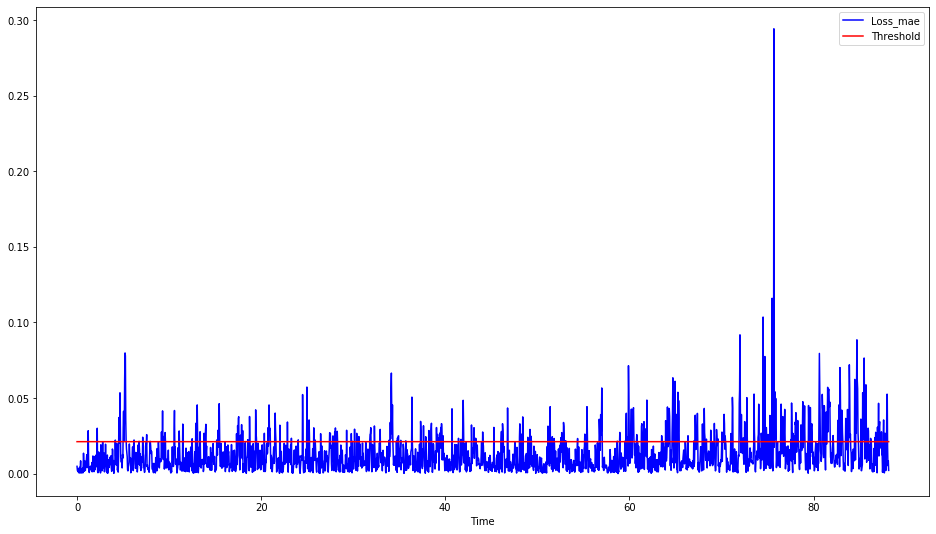

In [188]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=clustered_tflite_model_alt)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

# Train Predictions from TFLite model
tfl1_pred = np.empty((900,1,3))
for i in range(len(train)):
    interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i,0,:] = result
    
# Computing MAE Loss across all training points
loss = np.mean(np.abs(tfl1_pred - train), axis = 2)

# Plotting distribution of loss function to establish reasonable threshold for anomaly detection
scored1_train = pd.DataFrame(index=data.iloc[0:int(0.4*len(data)),0])
scored1_train['Loss_mae'] = loss
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored1_train['Loss_mae'], bins = 50, kde= True, color = 'blue');
plt.xlim([0.0,np.max(scored1_train['Loss_mae'])])

#Defining threshold values for loss anomaly detection as one standard deviation above the mean
thresh_clust_alt = np.mean(scored1_train['Loss_mae']) + np.std(scored1_train['Loss_mae'])
print(f'Threshold Value: {thresh_clust_alt}')

#Applying threshold value
scored1_train['Threshold'] = thresh_clust_alt
scored1_train['Anomaly'] = scored1_train['Loss_mae'] > scored1_train['Threshold']

# Test Predictions from TFLite model
tfl1_pred = np.empty((1350,1,3))
for i in range(len(test)):
    interpreter.set_tensor(input_details[0]["index"], test.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i,0,:] = result

# Computing MAE Loss across all test points
loss = np.mean(np.abs(tfl1_pred - test), axis = 2)
    
#Computing test set loss and applying threshold value for anomaly detection
scored1 = pd.DataFrame(index= data.iloc[(int(0.4*len(data))):,0])
scored1['Loss_mae'] = loss
scored1['Threshold'] = thresh_clust_alt
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

##Merging train and test loss data
scored_1 = pd.concat([scored1_train, scored1])

#Visualizing model output in full period
scored_1.plot(logy=False,  figsize=(16,9), color=['blue','red'])


In [58]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in bytes.
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    return os.path.getsize(zipped_file)

In [59]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped clustered Keras model: %.2f bytes" % (get_gzipped_model_size(clustered_keras_file)))
print("Size of gzipped clustered TFlite model: %.2f bytes" % (get_gzipped_model_size('model3_clust.tflite')))
print("Size of gzipped clustered TFlite model: %.2f bytes" % (get_gzipped_model_size('model_alt_3_clust.tflite')))

Size of gzipped baseline Keras model: 4837.00 bytes
Size of gzipped clustered Keras model: 3206.00 bytes
Size of gzipped clustered TFlite model: 2563.00 bytes
Size of gzipped clustered TFlite model: 4499.00 bytes


## Pruning

In [60]:
#Autoencoder with three dense layers and dropout
model3 = tf.keras.models.Sequential([
    Input(shape=(train.shape[1], train.shape[2]), name="input"),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(32, activation='relu'),
    Dense(train.shape[2], name = 'output'),
])


model3.compile(optimizer='adam', loss='mae')
model3.summary()

# Fitting model to the data
nb_epochs = 100
batch_size = 10
history1 = model3.fit(train, train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 20
validation_split = 0.05 # 5% of training set will be used for validation set. 

num_train = train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_train / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.75,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model3, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss='mae')

model_for_pruning.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1, 32)             128       
                                                                 
 dense_13 (Dense)            (None, 1, 8)              264       
                                                                 
 dense_14 (Dense)            (None, 1, 32)             288       
                                                                 
 output (Dense)              (None, 1, 3)              99        
                                                                 
Total params: 779
Trainable params: 779
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
86/86 [==============================] - 1s 3ms/step - loss: 0.2031 - val_loss: 0.0679
Epoch 2/100
86/86 [==============================] - 0s 1ms/step - loss: 0.0489 - val_los

/Users/akshay/opt/anaconda3/lib/python3.7/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/Users/akshay/opt/anaconda3/lib/python3.7/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/Users/akshay/opt/anaconda3/lib/python3.7/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=False)


In [61]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmpjuccsgv4.h5


In [62]:
run_model = tf.function(lambda x: model_for_export(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 1
INPUT_SIZE = 3
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model_for_export.inputs[0].dtype))

# model directory.
MODEL_DIR = "anomaly_det_mod"
model_for_export.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)

# converter.representative_dataset = representative_data_gen
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
pruned_tflite_model = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=pruned_tflite_model)

#Saving models
with open('model3_prune.tflite', 'wb') as f:
    f.write(pruned_tflite_model)
    
with open('c_model3_prune' + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_tflite_model, 'c_model3_prune'))

INFO:tensorflow:Assets written to: anomaly_det_mod/assets


INFO:tensorflow:Assets written to: anomaly_det_mod/assets


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the FULLY_CONNECTED op takes
tensor #0 and tensor #5 and tensor #4 as input and produces tensor #9 as output.

Subgraph#0 main(T#0) -> [T#12]
  Op#0 FULLY_CONNECTED(T#0, T#5, T#4) -> [T#9]
  Op#1 FULLY_CONNECTED(T#9, T#6, T#3) -> [T#10]
  Op#2 FULLY_CONNECTED(T#10, T#7, T#2) -> [T#11]
  Op#3 FULLY_CONNECTED(T#11, T#8, T#1) -> [T#12]

Tensors of Subgraph#0
  T#0(serving_default_x:0) shape:[1, 1, 3], type:FLOAT32
  T#1(sequential_4/output/BiasAdd/ReadVariableOp) shape:[3], type:FLOAT32 RO 12 bytes
  T#2(sequential_4/dense_14/BiasAdd/ReadVariableOp) shape:[32], type:FLOAT32 RO 128 bytes
  T#3(sequential_4/dense_13/BiasAdd/ReadVariableOp) shape:[8], type:FLOAT32 RO 32 bytes
  T#4(sequential_4/dense_12/BiasAdd/ReadVariableOp) shape:[32], type:FLOAT32 RO 128 bytes
  T#5(sequential_4/dense_12/Tensordot/MatMul) shape:[32, 3], type

In [63]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
# converter.representative_dataset = representative_data_gen
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# # Set the input and output tensors to uint8 (APIs added in r2.3)
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

pruned_tflite_model_alt = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=pruned_tflite_model_alt)

#Saving models
with open('model_alt_3_prune.tflite', 'wb') as f:
    f.write(pruned_tflite_model_alt)

with open('c_model_alt_3_prune' + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_tflite_model_alt, 'c_model_alt_3_prune'))

INFO:tensorflow:Assets written to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmp6mczru4i/assets


INFO:tensorflow:Assets written to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmp6mczru4i/assets


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the SHAPE op takes
tensor #0 as input and produces tensor #15 as output.

Subgraph#0 main(T#0) -> [T#58]
  Op#0 SHAPE(T#0) -> [T#15]
  Op#1 GATHER(T#15, T#6) -> [T#16]
  Op#2 REDUCE_PROD(T#16, T#8) -> [T#17]
  Op#3 GATHER(T#15, T#5) -> [T#18]
  Op#4 REDUCE_PROD(T#18, T#8) -> [T#19]
  Op#5 PACK(T#19, T#17) -> [T#20]
  Op#6 CONCATENATION(T#18, T#9) -> [T#21]
  Op#7 RESHAPE(T#0, T#20) -> [T#22]
  Op#8 FULLY_CONNECTED(T#22, T#11, T#-1) -> [T#23]
  Op#9 RESHAPE(T#23, T#21) -> [T#24]
  Op#10 ADD(T#24, T#4) -> [T#25]
  Op#11 SHAPE(T#25) -> [T#26]
  Op#12 GATHER(T#26, T#5) -> [T#27]
  Op#13 REDUCE_PROD(T#27, T#8) -> [T#28]
  Op#14 CONCATENATION(T#27, T#10) -> [T#29]
  Op#15 GATHER(T#26, T#6) -> [T#30]
  Op#16 REDUCE_PROD(T#30, T#8) -> [T#31]
  Op#17 PACK(T#28, T#31) -> [T#32]
  Op#18 RESHAPE(T#25, T#32) -> [T#33]
  Op#19 FULLY_CON

In [64]:
train_loss(pruned_tflite_model)

0.002002629884704947

Threshold Value: 0.0028076697992037505


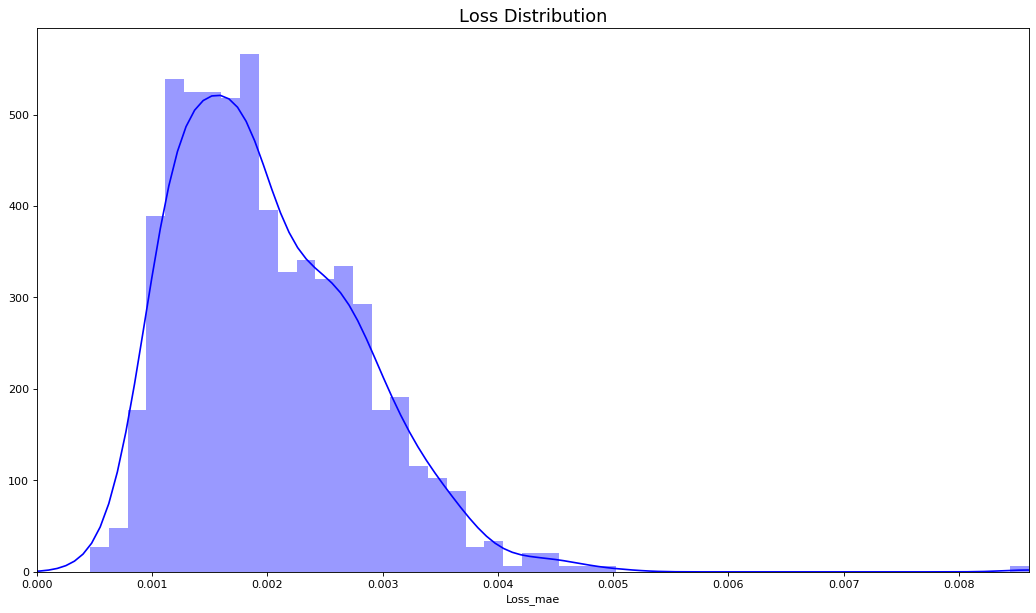

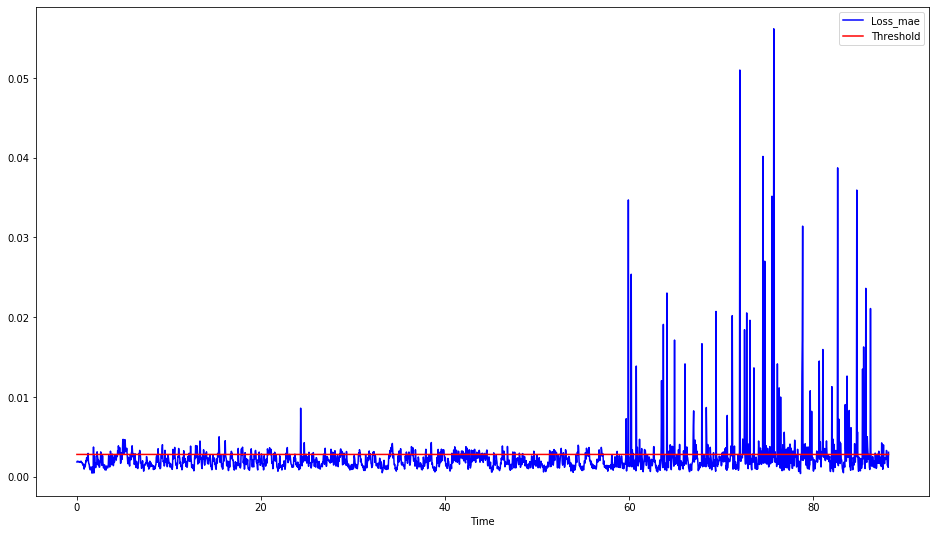

In [65]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=pruned_tflite_model)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

# Train Predictions from TFLite model
tfl1_pred = np.empty((900,1,3))
for i in range(len(train)):
    interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i,0,:] = result
    
# Computing MAE Loss across all training points
loss = np.mean(np.abs(tfl1_pred - train), axis = 2)

# Plotting distribution of loss function to establish reasonable threshold for anomaly detection
scored1_train = pd.DataFrame(index=data.iloc[0:int(0.4*len(data)),0])
scored1_train['Loss_mae'] = loss
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored1_train['Loss_mae'], bins = 50, kde= True, color = 'blue');
plt.xlim([0.0,np.max(scored1_train['Loss_mae'])])

#Defining threshold values for loss anomaly detection as one standard deviation above the mean
thresh_prune = np.mean(scored1_train['Loss_mae']) + np.std(scored1_train['Loss_mae'])
print(f'Threshold Value: {thresh_prune}')

#Applying threshold value
scored1_train['Threshold'] = thresh_prune
scored1_train['Anomaly'] = scored1_train['Loss_mae'] > scored1_train['Threshold']

# Test Predictions from TFLite model
tfl1_pred = np.empty((1350,1,3))
for i in range(len(test)):
    interpreter.set_tensor(input_details[0]["index"], test.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i,0,:] = result

# Computing MAE Loss across all test points
loss = np.mean(np.abs(tfl1_pred - test), axis = 2)
    
#Computing test set loss and applying threshold value for anomaly detection
scored1 = pd.DataFrame(index= data.iloc[(int(0.4*len(data))):,0])
scored1['Loss_mae'] = loss
scored1['Threshold'] = thresh_prune
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

##Merging train and test loss data
scored_1 = pd.concat([scored1_train, scored1])

#Visualizing model output in full period
scored_1.plot(logy=False,  figsize=(16,9), color=['blue','red'])


Threshold Value: 0.0028076697992037505


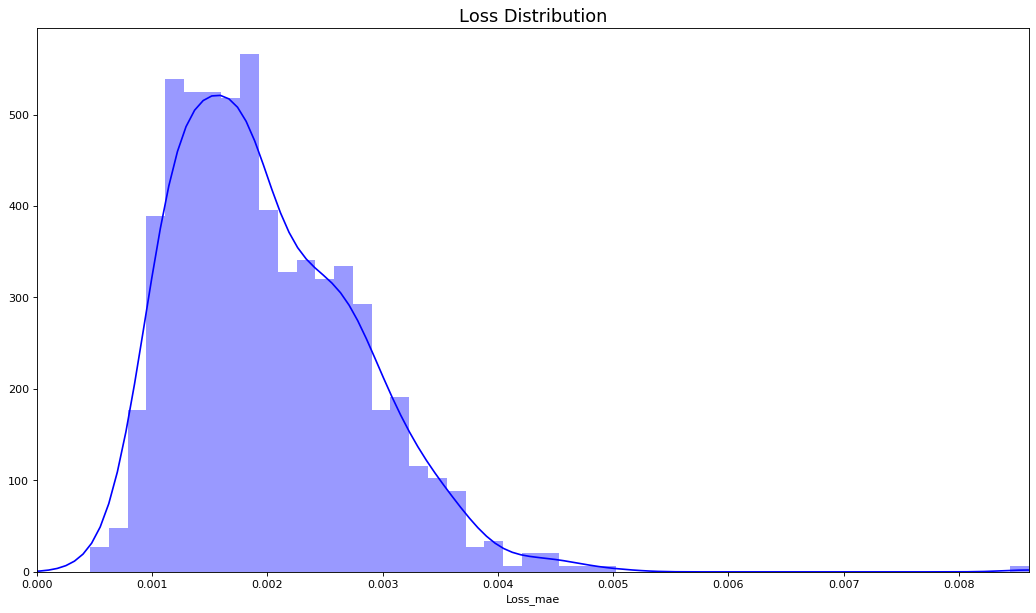

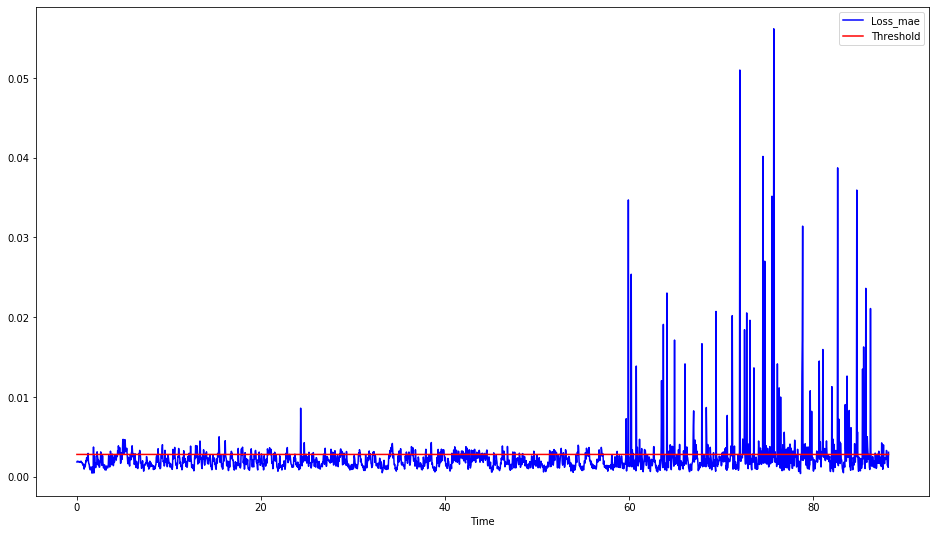

In [66]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=pruned_tflite_model_alt)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

# Train Predictions from TFLite model
tfl1_pred = np.empty((900,1,3))
for i in range(len(train)):
    interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i,0,:] = result
    
# Computing MAE Loss across all training points
loss = np.mean(np.abs(tfl1_pred - train), axis = 2)

# Plotting distribution of loss function to establish reasonable threshold for anomaly detection
scored1_train = pd.DataFrame(index=data.iloc[0:int(0.4*len(data)),0])
scored1_train['Loss_mae'] = loss
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored1_train['Loss_mae'], bins = 50, kde= True, color = 'blue');
plt.xlim([0.0,np.max(scored1_train['Loss_mae'])])

#Defining threshold values for loss anomaly detection as one standard deviation above the mean
thresh_prune_alt = np.mean(scored1_train['Loss_mae']) + np.std(scored1_train['Loss_mae'])
print(f'Threshold Value: {thresh_prune_alt}')

#Applying threshold value
scored1_train['Threshold'] = thresh_prune_alt
scored1_train['Anomaly'] = scored1_train['Loss_mae'] > scored1_train['Threshold']

# Test Predictions from TFLite model
tfl1_pred = np.empty((1350,1,3))
for i in range(len(test)):
    interpreter.set_tensor(input_details[0]["index"], test.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i,0,:] = result

# Computing MAE Loss across all test points
loss = np.mean(np.abs(tfl1_pred - test), axis = 2)
    
#Computing test set loss and applying threshold value for anomaly detection
scored1 = pd.DataFrame(index= data.iloc[(int(0.4*len(data))):,0])
scored1['Loss_mae'] = loss
scored1['Threshold'] = thresh_prune_alt
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

##Merging train and test loss data
scored_1 = pd.concat([scored1_train, scored1])

#Visualizing model output in full period
scored_1.plot(logy=False,  figsize=(16,9), color=['blue','red'])


In [67]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size('model3_prune.tflite')))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size('model_alt_3_prune.tflite')))

Size of gzipped baseline Keras model: 4837.00 bytes
Size of gzipped pruned Keras model: 4844.00 bytes
Size of gzipped pruned TFlite model: 3961.00 bytes
Size of gzipped pruned TFlite model: 5947.00 bytes


## Anomaly Detection Two-Way Table

General Idea:
Construct two-way table of anomaly classifications on entirety of test set

In [174]:
#Label test set as anomaly or normal
#Anomaly set will have arbitrary label True
test_times = data.iloc[(int(0.4*len(data))):,:]['Time']
test_labs = pd.DataFrame(data.iloc[(int(0.4*len(data))):,:]['Time'] > 60).rename(columns = {"Time":"Observed"}).reset_index(drop=True)

#Defining function for computing vector of predictions given TFLite model
def prediction_pipeline(model, data, thresh_val):
    # Run the model with TensorFlow Lite
    interpreter = tf.lite.Interpreter(model_content=model)
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()
    output_details = interpreter.get_output_details()

    #Predictions from TFLite model
    tfl_pred = np.empty((len(data),1,3))
    for i in range(len(data)):
        interpreter.set_tensor(input_details[0]["index"], data.astype('float32')[i:i+1,:,:])
        interpreter.invoke()
        result = interpreter.get_tensor(output_details[0]["index"])
        tfl_pred[i,0,:] = result
    
    #Threshold classification
    loss_vals = np.mean(np.abs(tfl_pred - test), axis = 2)
    pred_classes = pd.DataFrame(loss_vals > thresh_val).rename(columns = {0:'Pred'})
    
    #Construct single dataframe containing predicted and actual predictions
    results = pd.concat([pred_classes, test_labs], axis = 1)
    
    #Return the two-way table containing the 
    return results.groupby(["Pred", "Observed"]).size()


In [114]:
def precision(results):
    values = results.values
    
    return values[3]/(values[3] + values[2])

def recall(results):
    values = results.values
    
    return values[3]/(values[3] + values[1])

def f1_score(results):
    prec = precision(results)
    rec = recall(results)
    
    return (2*prec*rec)/(prec+rec)

def accuracy(results):
    values = results.values
    
    return (values[3] + values[0])/(np.sum(values))

In [126]:
def train_loss(model):
    # Run the model with TensorFlow Lite
    interpreter = tf.lite.Interpreter(model_content=model)
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()
    output_details = interpreter.get_output_details()

    #Predictions from TFLite model
    tfl1_pred = np.empty((900,1,3))
    for i in range(len(train)):
        interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
        interpreter.invoke()
        result = interpreter.get_tensor(output_details[0]["index"])
        tfl1_pred[i,0,:] = result
    tfl1_pred = tfl1_pred.reshape(900,3)
    return np.mean(np.abs(tfl1_pred - train.reshape(900,3)))

In [127]:
results = prediction_pipeline(tflite_model, test, thresh_reg)
results
print(f'Training Loss: {train_loss(tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.001570265586798389
Accuracy: 0.5533333333333333
Precision: 0.7357723577235772
Recall: 0.2517385257301808
F1-Score: 0.37512953367875645


In [128]:
results = prediction_pipeline(tflite_model_alt, test, thresh_reg)
results
print(f'Training Loss: {train_loss(tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.001570265586798389
Accuracy: 0.5533333333333333
Precision: 0.7357723577235772
Recall: 0.2517385257301808
F1-Score: 0.37512953367875645


In [129]:
results = prediction_pipeline(quantized_tflite_model, test, thresh_qai)
results
print(f'Training Loss: {train_loss(quantized_tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.010151542915334854
Accuracy: 0.5111111111111111
Precision: 0.7657657657657657
Recall: 0.11821974965229486
F1-Score: 0.20481927710843373


In [130]:
results = prediction_pipeline(quantized_tflite_model_alt, test, thresh_qai_alt)
results
print(f'Training Loss: {train_loss(quantized_tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.01071868805532102
Accuracy: 0.5111111111111111
Precision: 0.7706422018348624
Recall: 0.1168289290681502
F1-Score: 0.2028985507246377


In [131]:
results = prediction_pipeline(clustered_tflite_model, test, thresh_clust)
results
print(f'Training Loss: {train_loss(clustered_tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.011099317356488772
Accuracy: 0.5703703703703704
Precision: 0.7278688524590164
Recall: 0.3087621696801113
F1-Score: 0.43359375000000006


In [132]:
results = prediction_pipeline(clustered_tflite_model_alt, test, thresh_clust_alt)
results
print(f'Training Loss: {train_loss(clustered_tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.011099317356488772
Accuracy: 0.5703703703703704
Precision: 0.7278688524590164
Recall: 0.3087621696801113
F1-Score: 0.43359375000000006


In [134]:
results = prediction_pipeline(pruned_tflite_model, test, thresh_prune)
results
print(f'Training Loss: {train_loss(pruned_tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.002002629884704947
Accuracy: 0.5155555555555555
Precision: 0.6199261992619927
Recall: 0.2336578581363004
F1-Score: 0.33939393939393936


In [133]:
results = prediction_pipeline(pruned_tflite_model_alt, test, thresh_prune_alt)
results
print(f'Training Loss: {train_loss(pruned_tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.002002629884704947
Accuracy: 0.5155555555555555
Precision: 0.6199261992619927
Recall: 0.2336578581363004
F1-Score: 0.33939393939393936


## Anomaly Detection Voting Method

General Idea:
Batch sequences of observations into groups of 15. Conduct typical inference and anomaly detection. Create a simple batch vote schema with the voting threshold defined as one standard deviation above the mean of the number of anomaly predictions in each batch to classify all observations in the batch.


In [177]:
#Label train set as anomaly or normal
#Anomaly set will have arbitrary label True
train_times = data.iloc[:(int(0.4*len(data))),:]['Time']
train_labs = pd.DataFrame(data.iloc[:(int(0.4*len(data))),:]['Time'] > 60).rename(columns = {"Time":"Observed"}).reset_index(drop=True)


def voting_thresh(model, data, thresh):
        # Run the model with TensorFlow Lite
    interpreter = tf.lite.Interpreter(model_content=model)
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()
    output_details = interpreter.get_output_details()

    #Predictions from TFLite model
    tfl_pred = np.empty((len(data), 1 ,3))
    for i in range(len(train)):
        interpreter.set_tensor(input_details[0]["index"], data.astype('float32')[i:i+1,:,:])
        interpreter.invoke()
        result = interpreter.get_tensor(output_details[0]["index"])
        tfl_pred[i,0,:] = result
    
    #Threshold classification
    true = data
    loss_vals = np.resize(np.mean(np.abs(tfl_pred - true), axis = 2), (900,1))
    pred_classes = pd.DataFrame(loss_vals > thresh).rename(columns = {0:'Pred'})
    
    #Construct single dataframe containing predicted and actual predictions
    results = pd.concat([pred_classes, train_labs], axis = 1)
    
    #Voting scheme
    preds = results.values[:,0]
    batch_preds = np.resize(preds, (len(train), 15))
    votes = pd.DataFrame(batch_preds).sum(axis=1)
    voting_thresh = np.mean(votes) + np.std(votes)
    
    return voting_thresh

def voting_classification(model, data, thresh):
    # Run the model with TensorFlow Lite
    interpreter = tf.lite.Interpreter(model_content=model)
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()
    output_details = interpreter.get_output_details()

    #Predictions from TFLite model
    tfl_pred = np.empty((len(data), 1, 3))
    for i in range(len(test)):
        interpreter.set_tensor(input_details[0]["index"], data.astype('float32')[i:i+1,:,:])
        interpreter.invoke()
        result = interpreter.get_tensor(output_details[0]["index"])
        tfl_pred[i,0,:] = result
    
    #Threshold classification
    true = test
    loss_vals = np.resize(np.mean(np.abs(tfl_pred - true), axis = 2), (len(data),1))
    pred_classes = pd.DataFrame(loss_vals > thresh).rename(columns = {0:'Pred'})

    #Construct single dataframe containing initial predictions and actual values
    results = pd.concat([pred_classes, test_labs], axis = 1)

    #Voting scheme
    preds = results.values[:,0]
    batch_preds = np.resize(preds, (int(len(test)/15), 15))
    votes = pd.DataFrame(batch_preds).sum(axis=1)
    voting_threshold = voting_thresh(model, train, thresh)
    voted_pred = (votes > voting_threshold)
    ind_votes = np.resize((np.array([voted_pred for i in range(15)]).T), (len(test)*15, 1))
    plt.hist(votes)
    
    #Construct single dataframe containing final, voted predictions and actual values
    pred_classes = pd.DataFrame(ind_votes).rename(columns = {0:'Pred'})
    results = pd.concat([pred_classes, test_labs], axis = 1)
    
    #Return the two-way table containing the 
    return results.groupby(["Pred", "Observed"]).size()

In [178]:
results

Pred   Observed
False  False       480
       True        195
True   False       151
       True        524
dtype: int64

Training Loss: 0.001570265586798389
Accuracy: 0.7437037037037038
Precision: 0.7762962962962963
Recall: 0.7287899860917941
F1-Score: 0.7517934002869441


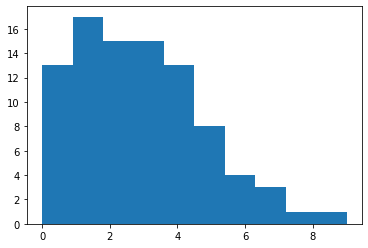

In [179]:
results = voting_classification(tflite_model, test, thresh_reg)
results
print(f'Training Loss: {train_loss(tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.001570265586798389
Accuracy: 0.7437037037037038
Precision: 0.7762962962962963
Recall: 0.7287899860917941
F1-Score: 0.7517934002869441


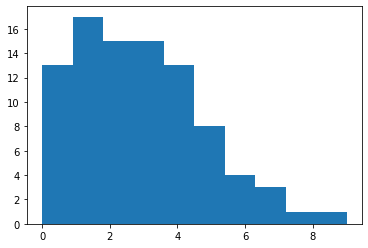

In [180]:
results = voting_classification(tflite_model_alt, test, thresh_reg)
results
print(f'Training Loss: {train_loss(tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')


Training Loss: 0.010151542915334854
Accuracy: 0.6451851851851852
Precision: 0.7857142857142857
Recall: 0.45897079276773295
F1-Score: 0.5794556628621598


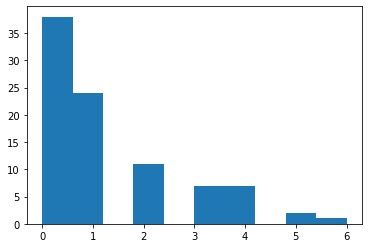

In [181]:
results = voting_classification(quantized_tflite_model, test, thresh_qai)
results
print(f'Training Loss: {train_loss(quantized_tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')



Training Loss: 0.01071868805532102
Accuracy: 0.6451851851851852
Precision: 0.7857142857142857
Recall: 0.45897079276773295
F1-Score: 0.5794556628621598


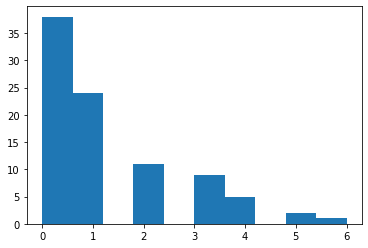

In [182]:
results = voting_classification(quantized_tflite_model_alt, test, thresh_qai_alt)
results
print(f'Training Loss: {train_loss(quantized_tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')



Training Loss: 0.011099317356488772
Accuracy: 0.7103703703703703
Precision: 0.7733333333333333
Recall: 0.6453407510431154
F1-Score: 0.7035633055344958


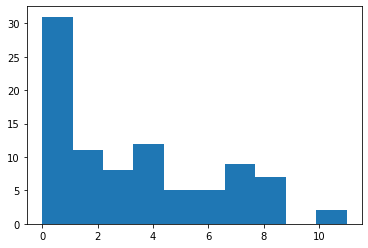

In [183]:
results = voting_classification(clustered_tflite_model, test, thresh_clust)
results
print(f'Training Loss: {train_loss(clustered_tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')



Training Loss: 0.011099317356488772
Accuracy: 0.7103703703703703
Precision: 0.7733333333333333
Recall: 0.6453407510431154
F1-Score: 0.7035633055344958


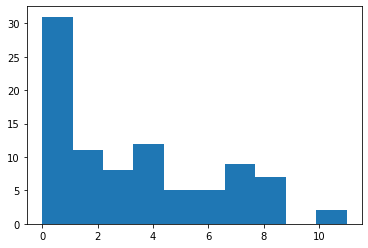

In [184]:
results = voting_classification(clustered_tflite_model_alt, test, thresh_clust_alt)
results
print(f'Training Loss: {train_loss(clustered_tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.002002629884704947
Accuracy: 0.5118518518518519
Precision: 0.6
Recall: 0.25034770514603616
F1-Score: 0.35328753680078506


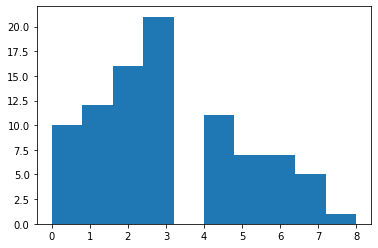

In [185]:
results = voting_classification(pruned_tflite_model, test, thresh_prune)
results
print(f'Training Loss: {train_loss(pruned_tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.002002629884704947
Accuracy: 0.5118518518518519
Precision: 0.6
Recall: 0.25034770514603616
F1-Score: 0.35328753680078506


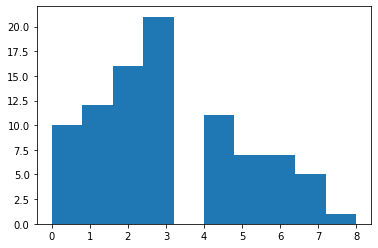

In [186]:
results = voting_classification(pruned_tflite_model_alt, test, thresh_prune_alt)
results
print(f'Training Loss: {train_loss(pruned_tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')